# Task 2 - Exploratory Data Analysis (EDA)

Importing Libraries and Loading data

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [9]:
# Load data 
df = pd.read_csv("../data/raw/data.csv", low_memory=False)
df.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


1. Overview of the Data

In [13]:
# Number of Columns and Rows
print(f"Data shape: {df.shape}")

# Column Names & Types
print(df.dtypes)


Data shape: (95662, 16)
TransactionId            object
BatchId                  object
AccountId                object
SubscriptionId           object
CustomerId               object
CurrencyCode             object
CountryCode               int64
ProviderId               object
ProductId                object
ProductCategory          object
ChannelId                object
Amount                  float64
Value                     int64
TransactionStartTime     object
PricingStrategy           int64
FraudResult               int64
dtype: object


2. Summary Statistics

In [23]:

print("=== Numerical Features Summary ===")
numerical_cols = ['Amount', 'Value']
display(df[numerical_cols].describe().T)


=== Numerical Features Summary ===


,count,mean,std,min,25%,50%,75%,max
Amount,95662.0,6717.846433,123306.797164,-1000000.0,-50.0,1000.0,2800.0,9880000.0
Value,95662.0,9900.583941,123122.087776,2.0,275.0,1000.0,5000.0,9880000.0


In [20]:
print("\n=== Categorical & Datetime Summary ===")

# TransactionStartTime parsing
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], errors='coerce')
print(f"TransactionStartTime range: {df['TransactionStartTime'].min()} → {df['TransactionStartTime'].max()}")
print(f"Unique Customers: {df['CustomerId'].nunique():,}")
print(f"Unique Accounts: {df['AccountId'].nunique():,}")


=== Categorical & Datetime Summary ===
TransactionStartTime range: 2018-11-15 02:18:49+00:00 → 2019-02-13 10:01:28+00:00
Unique Customers: 3,742
Unique Accounts: 3,633


3. Distribution of Numerical Features

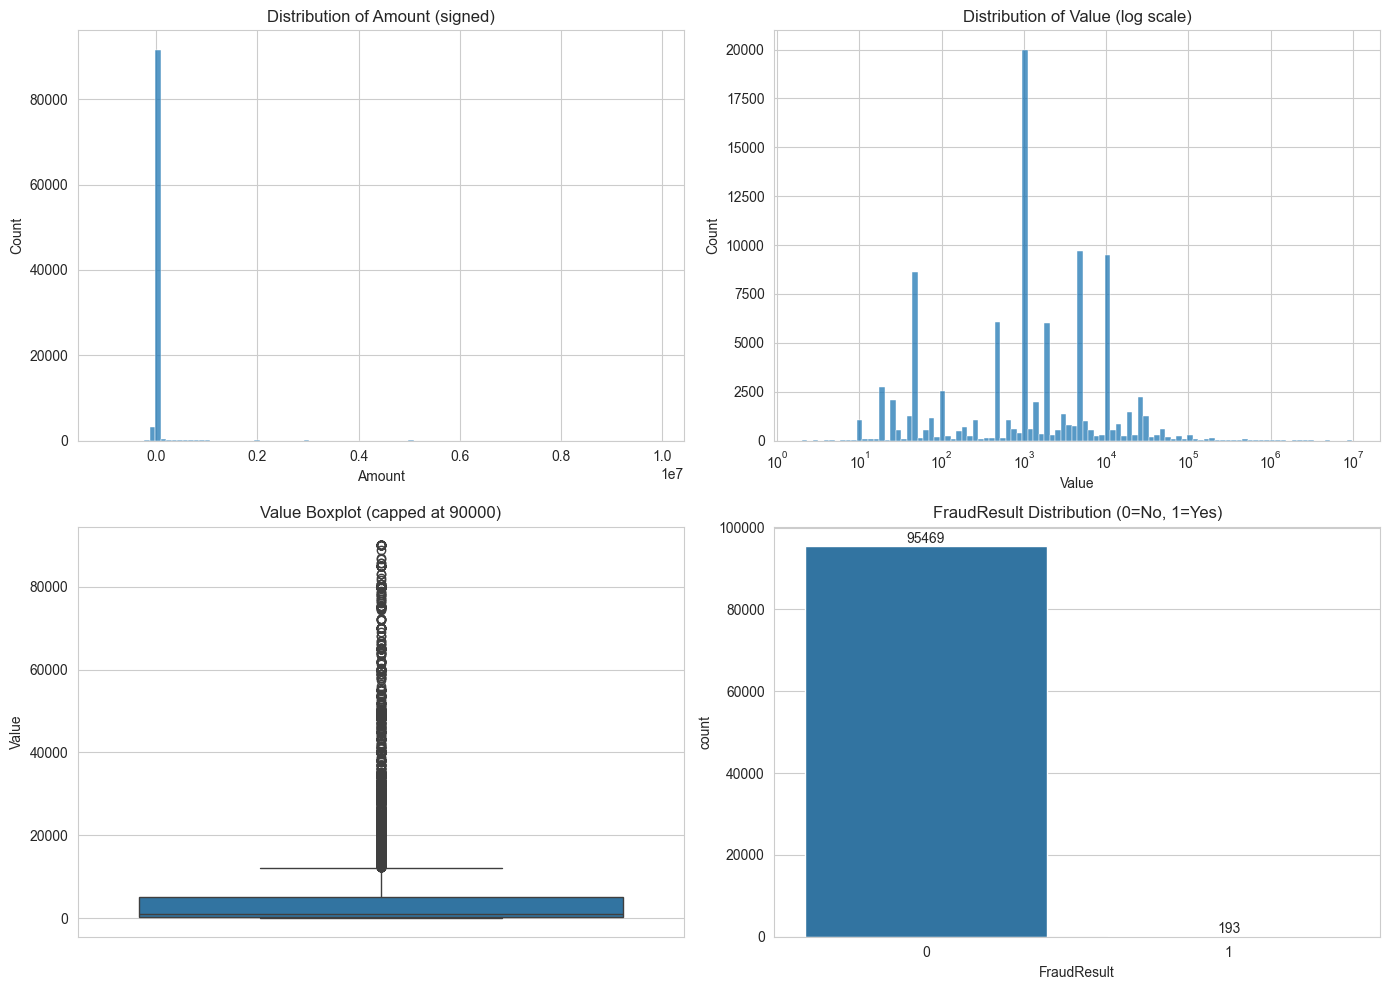

In [26]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Amount (signed)
sns.histplot(df['Amount'], bins=100, ax=axes[0,0], kde=False)
axes[0,0].set_title('Distribution of Amount (signed)')

# Value (absolute, log scale)
sns.histplot(df['Value'], bins=100, ax=axes[0,1], kde=False, log_scale=True)
axes[0,1].set_title('Distribution of Value (log scale)')

# Boxplot (99th percentile capped for visibility)
cap = df['Value'].quantile(0.99)
sns.boxplot(data=df[df['Value'] <= cap], y='Value', ax=axes[1,0])
axes[1,0].set_title(f'Value Boxplot (capped at {cap:.0f})')

# FraudResult
sns.countplot(data=df, x='FraudResult', ax=axes[1,1])
axes[1,1].set_title('FraudResult Distribution (0=No, 1=Yes)')
axes[1,1].bar_label(axes[1,1].containers[0])

plt.tight_layout()
plt.show()


4. Distribution of Categorical Features

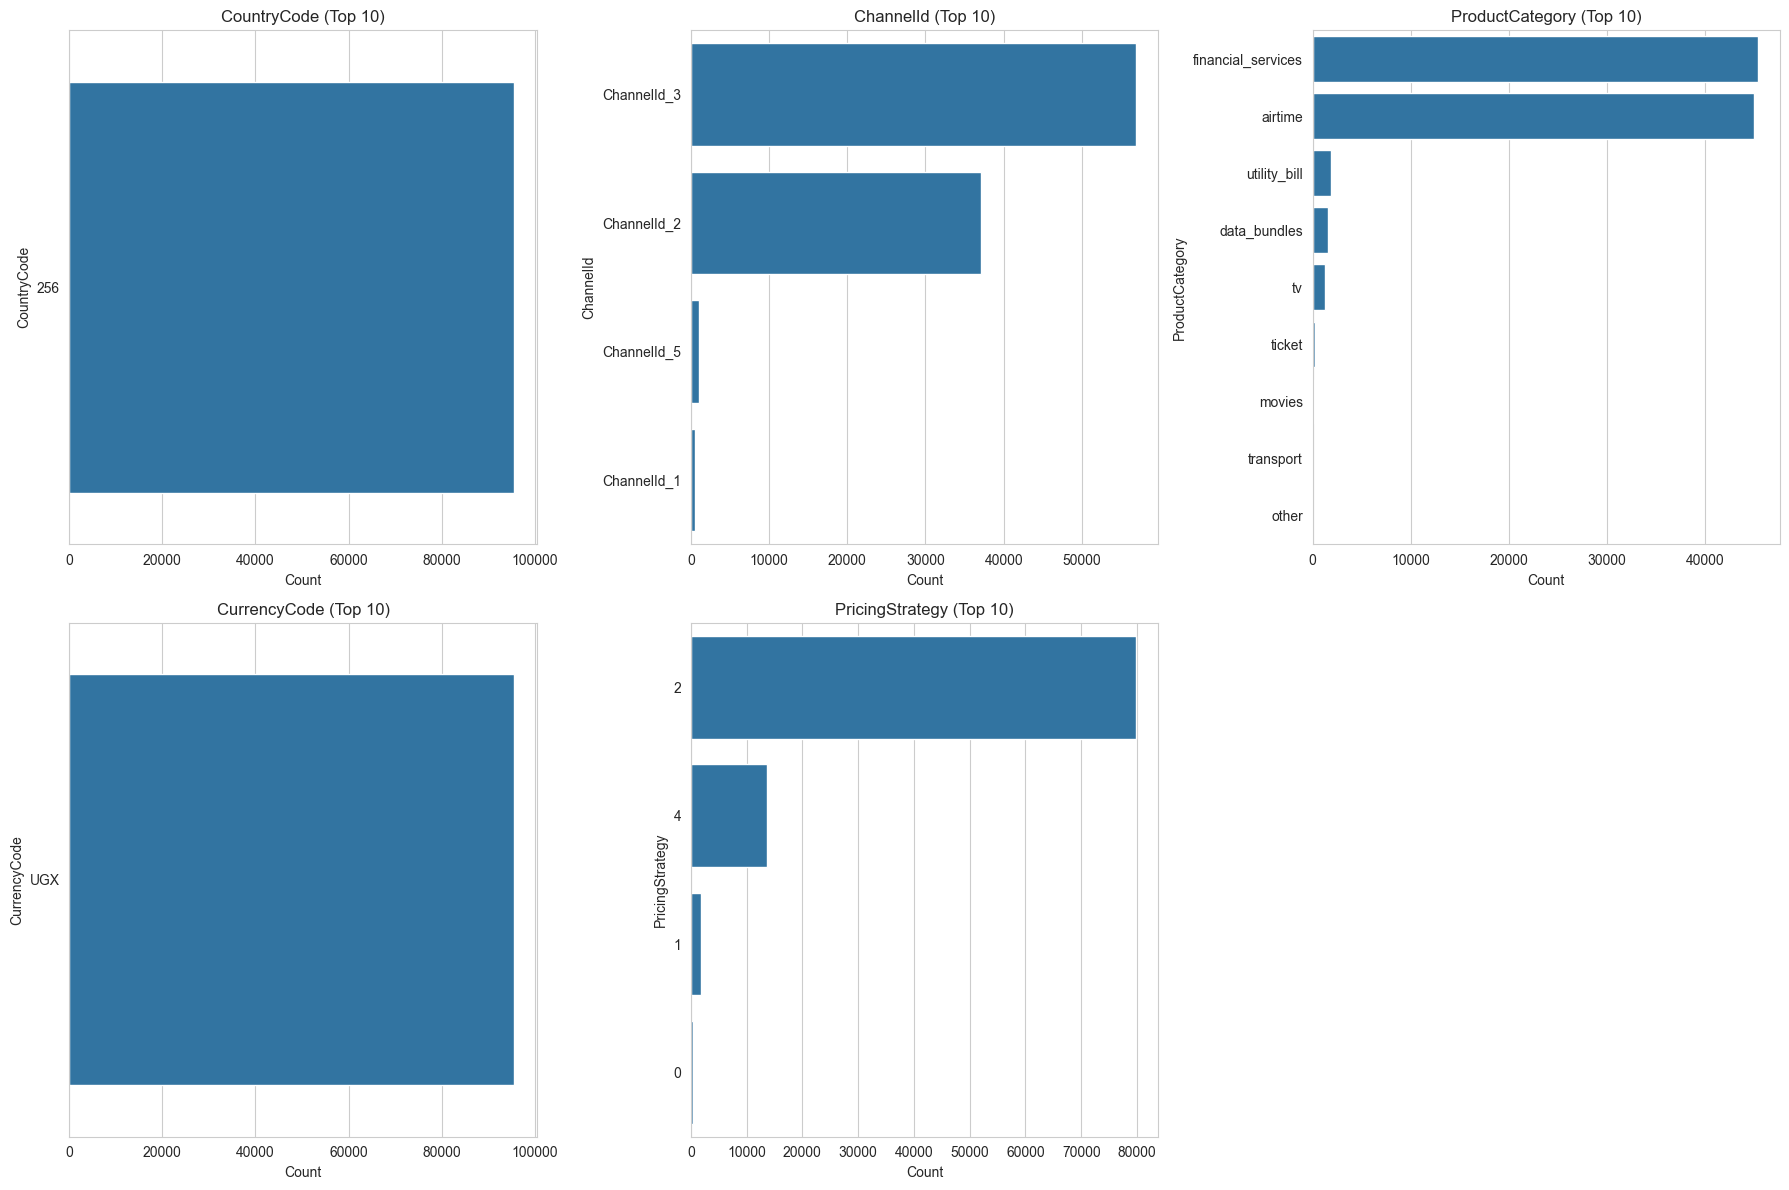

In [27]:
categorical_cols = ['CountryCode', 'ChannelId', 'ProductCategory', 'CurrencyCode', 'PricingStrategy']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    if col in df.columns:
        top10 = df[col].value_counts().head(10)
        sns.barplot(x=top10.values, y=top10.index.astype(str), ax=axes[i])
        axes[i].set_title(f'{col} (Top 10)')
        axes[i].set_xlabel('Count')

# Hide unused subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

5. Correlation Analysis (Numerical + Aggregated User-Level)

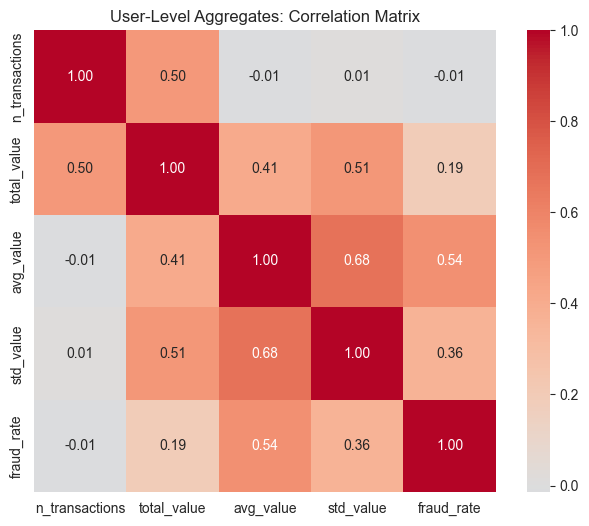

In [28]:
# Create user-level aggregates for correlation (only users with ≥2 transactions)
user_stats = df.groupby('CustomerId').agg(
    n_transactions=('TransactionId', 'count'),
    total_value=('Value', 'sum'),
    avg_value=('Value', 'mean'),
    std_value=('Value', 'std'),
    fraud_rate=('FraudResult', 'mean')
).reset_index()

# Fill NaN std (for single-transaction users, std=0)
user_stats['std_value'] = user_stats['std_value'].fillna(0)

# Select numeric columns
corr_cols = ['n_transactions', 'total_value', 'avg_value', 'std_value', 'fraud_rate']
corr_matrix = user_stats[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", square=True)
plt.title('User-Level Aggregates: Correlation Matrix')
plt.show()

6. Identifying Missing Values

In [ ]:
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'missing_count': missing,
    'missing_pct': missing_pct
}).sort_values('missing_pct', ascending=False)

print("=== Missing Values ===")
display(missing_df['missing_count'])


=== Missing Values ===


TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount                  0
Value                   0
TransactionStartTime    0
PricingStrategy         0
FraudResult             0
Name: missing_count, dtype: int64

In [39]:
# Duplicates
print("Duplicate TransactionId:", df['TransactionId'].duplicated().sum())
print("Duplicate rows:", df.duplicated().sum())

Duplicate TransactionId: 0
Duplicate rows: 0


7. Outlier Detection (Boxplots for Key Numerical Features)

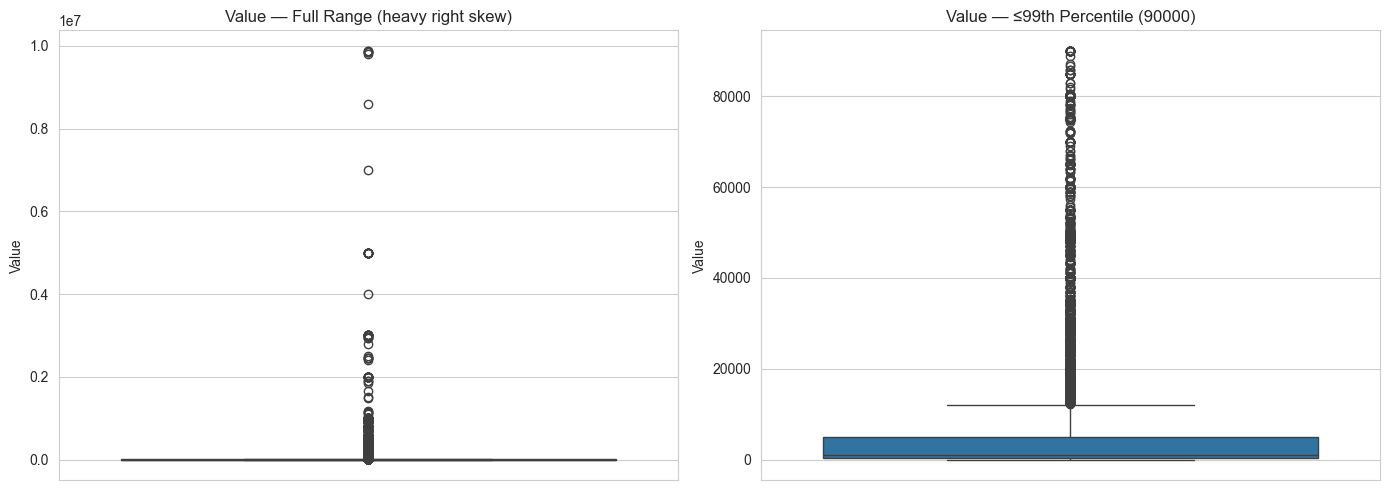

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Value (full range)
sns.boxplot(data=df, y='Value', ax=axes[0])
axes[0].set_title('Value — Full Range (heavy right skew)')

# Zoomed boxplot: 0–99th percentile
cap99 = df['Value'].quantile(0.99)
sns.boxplot(data=df[df['Value'] <= cap99], y='Value', ax=axes[1])
axes[1].set_title(f'Value — ≤99th Percentile ({cap99:.0f})')

plt.tight_layout()
plt.show()

In [41]:
# Identify extreme outliers (top 0.1%)
threshold = df['Value'].quantile(0.999)
extreme_outliers = df[df['Value'] > threshold]
print(f"\n Extreme Outliers (>99.9th percentile = {threshold:.0f}): {len(extreme_outliers)} records")
print("Top 5 highest-value transactions:")
display(extreme_outliers[['TransactionId', 'CustomerId', 'Value', 'ProductCategory', 'CountryCode']].head())


 Extreme Outliers (>99.9th percentile = 1000000): 81 records
Top 5 highest-value transactions:


,TransactionId,CustomerId,Value,ProductCategory,CountryCode
5093,TransactionId_45692,CustomerId_4391,5000000,financial_services,256
5125,TransactionId_6570,CustomerId_4453,3000000,financial_services,256
5133,TransactionId_104304,CustomerId_4453,2000000,financial_services,256
9282,TransactionId_35420,CustomerId_4453,2000000,airtime,256
13142,TransactionId_66303,CustomerId_1858,2000000,financial_services,256


Top 5 EDA Insights

**1. Extreme Right-Skew in Transaction Values**
Median transaction value is $1,000, but the 75th percentile jumps to $5,000, and the maximum reaches $9.88M.
The top 0.1% of transactions (> $1M) — 81 records — are dominated by financial_services and airtime in CountryCode=256 (Uganda).

**2. Very Low Fraud Incidence**
Fraud rate is only ~0.6% (based on FraudResult), indicating a generally clean dataset.
However, high-value fraud cases exist (e.g., $5M transaction flagged as fraud), suggesting fraud correlates with extreme values.


**3. Strong Geographic and Product Concentration**
While your data contains multiple country codes, the extreme-value outliers and high-volume activity cluster in CountryCode=256 (Uganda).
ProductCategory = "financial_services" and "airtime" dominate high-value transactions.


**4. High User Transaction Frequency with Low Unique-to-Account Ratio**
3,742 unique customers vs. 3,633 unique accounts → many users have multiple accounts (e.g., shared devices/families).
Mean transactions per user ≈ 25.6, indicating rich behavioral history for RFM modeling.

**5. No Missing Data or Duplicates **
Zero missing values and zero duplicate TransactionIds or rows — High-Quality Raw Dataset.